In [38]:
import pandas as pd
from langdetect import detect
import re
import unicodedata


# Load dataset
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("beridzeg45/book-reviews")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Book Reviews.csv")
df.head()

Path to dataset files: /Users/eiriksundsoy/.cache/kagglehub/datasets/beridzeg45/book-reviews/versions/1


,Unnamed: 0,Book,Review,Review Date
0,0,To Kill a Mockingbird,/// gentle reminder that this is not the time ...,"March 24, 2022"
1,1,To Kill a Mockingbird,\n|\n|6.0 stars. I know I am risking a serious...,"May 24, 2011"
2,2,To Kill a Mockingbird,\n|\n|Looking for a new book but don't want to...,"December 10, 2020"
3,3,To Kill a Mockingbird,"To Kill a Mockingbird, Harper Lee|To Kill a Mo...","July 1, 2022"
4,4,To Kill a Mockingbird,Why is it when I pick up | To Kill A Mockingbi...,"October 25, 2009"


In [39]:
df['Book'].describe()

count                     32081
unique                     1096
top       To Kill a Mockingbird
freq                         30
Name: Book, dtype: object

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32081 entries, 0 to 32080
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   32081 non-null  int64 
 1   Book         32081 non-null  object
 2   Review       31772 non-null  object
 3   Review Date  32081 non-null  object
dtypes: int64(1), object(3)
memory usage: 1002.7+ KB


In [41]:
#Drop rows with missing values

df = df.dropna(subset=['Book', 'Review'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31772 entries, 0 to 32080
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   31772 non-null  int64 
 1   Book         31772 non-null  object
 2   Review       31772 non-null  object
 3   Review Date  31772 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [43]:
# --- Language filter ---
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df = df[df['Review'].apply(is_english)].reset_index(drop=True)

# --- Normalize + clean reviews ---
def clean_text(text):

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove emojis and symbols
    text = ''.join(c for c in text if unicodedata.category(c)[0] != "So")

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    return text

df['Review'] = df['Review'].astype(str).apply(clean_text)

#Remove duplicate reviews
df = df.drop_duplicates(subset=['Book', 'Review']).reset_index(drop=True)

# Word count for later filtering
df['review_word_count'] = df['Review'].str.split().str.len()


In [44]:
# Optional: check review word count distribution
df['review_word_count'] = df['Review'].str.split().str.len()
print("\n Review word count distribution:")
print(df['review_word_count'].describe())



 Review word count distribution:
count    23045.000000
mean       372.936255
std        405.346083
min          1.000000
25%        113.000000
50%        250.000000
75%        487.000000
max       3656.000000
Name: review_word_count, dtype: float64


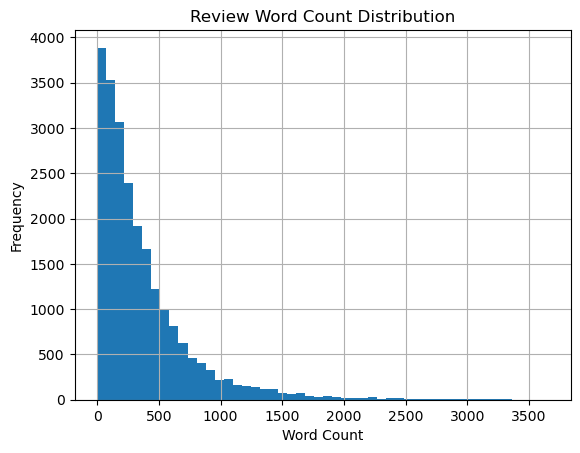

In [45]:
import matplotlib.pyplot as plt

df['review_word_count'].hist(bins=50)
plt.title("Review Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


In [46]:
# Aggregate reviews into a structured, model-friendly format
aggregated_reviews = (
    df
    .groupby('Book')['Review']
    .apply(lambda reviews: '\n'.join([f"Review: {r.strip()}" for r in reviews]))
    .reset_index()
    .rename(columns={'Review': 'Aggregated_Reviews'})
)

# Calculate total word count per book
aggregated_reviews['Total_Word_Count'] = aggregated_reviews['Aggregated_Reviews'].str.split().str.len()


In [47]:
# Filter out books with fewer than 200 total words, to make sure the models dont try to summarize books with little data to make summaries
aggregated_reviews = aggregated_reviews[aggregated_reviews['Total_Word_Count'] >= 200].reset_index(drop=True)

In [48]:
print("\n Preview of aggregated reviews:")
print(aggregated_reviews.head())


 Preview of aggregated reviews:
                    Book                                 Aggregated_Reviews  \
0                  10:04  Review: I’m going to let the text of 10:04 by ...   
1                   1984  Review: YOU. ARE. THE. DEAD.| Oh my God. I got...   
2      1Q84 (1Q84, #1-3)  Review: 1Q84 is undoubtedly the biggest litera...   
3  2001: A Space Odyssey  Review: The book is always better than the fil...   
4                   2666  Review: Roberto Bolaño's |2666| has been descr...   

   Total_Word_Count  
0              9190  
1              8255  
2             13200  
3             10390  
4             17994  


In [49]:
print("\n Total word count per book (after filtering):")
print(aggregated_reviews['Total_Word_Count'].describe())


 Total word count per book (after filtering):
count     1085.000000
mean      7941.508756
std       4321.011440
min        210.000000
25%       4848.000000
50%       7553.000000
75%      10746.000000
max      31072.000000
Name: Total_Word_Count, dtype: float64


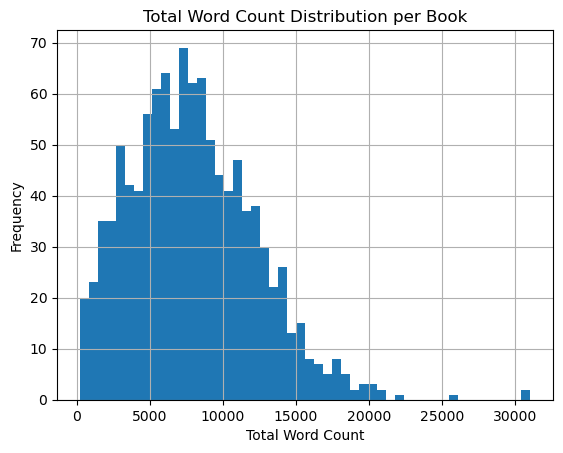

In [50]:
# Visualize with a histogram distribution of total word counts per book
aggregated_reviews['Total_Word_Count'].hist(bins=50)
plt.title("Total Word Count Distribution per Book")
plt.xlabel("Total Word Count")
plt.ylabel("Frequency")
plt.show()

In [78]:
#print the percentile of 'The History of the Siege of Lisbon' and 'Flaubert's Parrot'
book_titles = ['Cataract', 'The Afternoon of a Writer', 'The History of the Siege of Lisbon', "Flaubert's Parrot", 'Infinite Jest']
for title in book_titles:
    if title in aggregated_reviews['Book'].values:
        word_count = aggregated_reviews.loc[aggregated_reviews['Book'] == title, 'Total_Word_Count'].values[0]
        percentile = (aggregated_reviews['Total_Word_Count'] < word_count).mean() * 100
        print(f"'{title}' has a total word count of {word_count}, which is in the {percentile:.5f}th percentile of all books.")
    else:
        print(f"'{title}' not found in the dataset.")

'Cataract' has a total word count of 533, which is in the 1.01382th percentile of all books.
'The Afternoon of a Writer' has a total word count of 2024, which is in the 6.82028th percentile of all books.
'The History of the Siege of Lisbon' has a total word count of 5381, which is in the 30.13825th percentile of all books.
'Flaubert's Parrot' has a total word count of 9241, which is in the 64.88479th percentile of all books.
'Infinite Jest' has a total word count of 31072, which is in the 99.90783th percentile of all books.


In [88]:
# Here we find the books with word counts in 5 different categories, to make sure the models perform well across a range of review content.
percentiles = [0.01, 0.068, 0.302, 0.649, 0.9999]
targets = aggregated_reviews['Total_Word_Count'].quantile(percentiles)

selected_books = pd.concat([
    aggregated_reviews.iloc[(aggregated_reviews['Total_Word_Count'] - target).abs().argsort().head(1)]
    for target in targets
]).drop_duplicates(subset='Book').reset_index(drop=True)

print("\n Books selected for testing:")
print(selected_books[['Book', 'Total_Word_Count']])

print(df.columns)


 Books selected for testing:
                                 Book  Total_Word_Count
0                            Cataract               533
1           The Afternoon of a Writer              2024
2  The History of the Siege of Lisbon              5381
3                   Flaubert's Parrot              9241
4                       Infinite Jest             31072
Index(['Unnamed: 0', 'Book', 'Review', 'Review Date', 'review_word_count'], dtype='object')


In [89]:
# Books to include that we have read and can manually inspect
books_to_add = [
    'To Kill a Mockingbird', '1984', 'Jane Eyre', 'Animal Farm', 'Crime and Punishment'
]

missing_books = [book for book in books_to_add if book not in selected_books['Book'].values]

additional_books = aggregated_reviews[aggregated_reviews['Book'].isin(missing_books)]

selected_books = pd.concat([selected_books, additional_books], ignore_index=True)

# Preview result
print("\n Final book list for testing:")
print(selected_books[['Book', 'Total_Word_Count']])



 Final book list for testing:
                                 Book  Total_Word_Count
0                            Cataract               533
1           The Afternoon of a Writer              2024
2  The History of the Siege of Lisbon              5381
3                   Flaubert's Parrot              9241
4                       Infinite Jest             31072
5                                1984              8255
6                         Animal Farm              7582
7                Crime and Punishment             12853
8                           Jane Eyre             14592
9               To Kill a Mockingbird             11975


In [116]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import re

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

prompt = ()

subset = selected_books  

book_summaries = {}
for i, row in subset.iterrows():
    book = row['Book']
    text = row['Aggregated_Reviews']
    print(f"Summarizing {i+1}/{len(subset)}: {book}")


    words = text.split()
    chunks = [' '.join(words[i:i + 500]) for i in range(0, len(words), 500)]
    chunk_input = ' '.join(chunks[:2])


    input_text = f"{prompt}\n\n{chunk_input}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)

    output_ids = model.generate(
        **inputs,
        max_length=140,
        min_length=60,
        num_beams=6,
    )

    result = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    book_summaries[book] = result

# Print summaries
for book, summary in book_summaries.items():
    print(f"\nSummary for: {book}")
    print(f"- {summary}")



Summarizing 1/10: Cataract
Summarizing 2/10: The Afternoon of a Writer
Summarizing 3/10: The History of the Siege of Lisbon
Summarizing 4/10: Flaubert's Parrot
Summarizing 5/10: Infinite Jest
Summarizing 6/10: 1984
Summarizing 7/10: Animal Farm
Summarizing 8/10: Crime and Punishment
Summarizing 9/10: Jane Eyre
Summarizing 10/10: To Kill a Mockingbird

Summary for: Cataract
- Mykhaylo Osadchy's |Cataract| is world-class on the level of the novel (as shalamov for the short story) The author references so many people with similar names that even the footnotes were of little use. The book proves that we are lucky to live where we live, and to not live under the circumstances that the Soviets lived under.

Summary for: The Afternoon of a Writer
- Peter Handke's short novel is about a writer who suffers from writer's block. The narrator takes a walk around town to get rid of the block. It is a meditation on what it is to live one of the many days that a writer may live. The author says he wa

In [117]:
from bert_score import score
from prettytable import PrettyTable

# Prepare candidate summaries and references
candidates = [book_summaries[book] for book in selected_books['Book']]
references = [selected_books[selected_books['Book'] == book]['Aggregated_Reviews'].values[0]
              for book in selected_books['Book']]

# Compute BERT scores
P, R, F1 = score(candidates, references, lang="en", verbose=True)

# Initialize table
table = PrettyTable()
table.field_names = ["Book Title", "F1 Score", "Precision", "Recall"]

# Add rows
for i, book in enumerate(selected_books['Book']):
    table.add_row([
        book,
        f"{F1[i].item():.2f}",
        f"{P[i].item():.2f}",
        f"{R[i].item():.2f}"
    ])

# Print table and average
print("\n BERTScore Results:")
print(table)
print(f"\n Average F1 Score: {F1.mean().item():.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 7.67 seconds, 1.30 sentences/sec

 BERTScore Results:
+------------------------------------+----------+-----------+--------+
|             Book Title             | F1 Score | Precision | Recall |
+------------------------------------+----------+-----------+--------+
|              Cataract              |   0.85   |    0.89   |  0.80  |
|     The Afternoon of a Writer      |   0.84   |    0.88   |  0.80  |
| The History of the Siege of Lisbon |   0.83   |    0.88   |  0.79  |
|         Flaubert's Parrot          |   0.87   |    0.95   |  0.81  |
|           Infinite Jest            |   0.80   |    0.83   |  0.77  |
|                1984                |   0.85   |    0.91   |  0.80  |
|            Animal Farm             |   0.86   |    0.93   |  0.81  |
|        Crime and Punishment        |   0.86   |    0.92   |  0.80  |
|             Jane Eyre              |   0.85   |    0.90   |  0.80  |
|       To Kill a Mockingbird        |   0.88   |    0.94   |  0.83  |
+--------------